## Mapping Austin 311 Calls from 2014 - 2016

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon

In [2]:
#Read the csv file that was downloaded from the City of Austin: "https://data.austintexas.gov/"
Austin_311_df = pd.read_csv('data/All_Austin_311.csv',low_memory=False)

Austin_311_df.head()

,incident_zip,owning_department,complaint_description,complaint_type,latitude,longitude,year,month
0,78741,Animal Services Office,Loose Dog,ACLONAG,30.224549,-97.690675,2015,1
1,78757,Animal Services Office,Loose Dog,ACLONAG,30.350881,-97.747492,2016,5
2,78744,Animal Services Office,Loose Animal (not dog),ACLOANIM,30.199263,-97.711366,2014,1
3,78727,Austin Code Department,Austin Code - Request Code Officer,CODECOMP,30.425112,-97.707188,2014,11
4,78723,Animal Services Office,Animal - Proper Care,ACPROPER,30.311821,-97.669302,2014,7


### Tom Berton mapped the density of 311 calls in Travis count using the Basemap module in Matplotlib. 

In [3]:
#Use the 'clean_Austin_311_df' and keep the approriate columns for this analysis.

austin_lat_lon = Austin_311_df[["incident_zip", "owning_department","latitude", "longitude"]]

# Change the zip to an integer
austin_lat_lon["incident_zip"] = austin_lat_lon["incident_zip"].astype(int)
austin_lat_lon = austin_lat_lon.rename(columns={"incident_zip":"Zip Code","owning_department":"Number of Complaints",
                                              "latitude": "Lat", "longitude":"Lon"})

# Get the number of complaints from the "Department" and means of the Lat and Lon.
atx_zip_by_latlon = austin_lat_lon.groupby("Zip Code").agg({"Number of Complaints": 'count', "Lat": 'mean', "Lon": 'mean'})
atx_zip_by_latlon.head()

/Users/tom/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Number of Complaints,Lat,Lon
Zip Code,,,
78610,31,30.104558,-97.776716
78613,10,30.459545,-97.829108
78617,3276,30.178763,-97.633562
78620,1,30.284697,-98.067527
78621,1,30.382937,-97.392721


In [4]:
total = atx_zip_by_latlon['Number of Complaints'].sum()
print(total)

422827


In [5]:
atx_zip_by_latlon["Coordinates"] = atx_zip_by_latlon[['Lat', 'Lon']].apply(tuple, axis=1)
atx_zip_by_latlon.head()

,Number of Complaints,Lat,Lon,Coordinates
Zip Code,,,,
78610,31,30.104558,-97.776716,"(30.1045575026, -97.7767162003)"
78613,10,30.459545,-97.829108,"(30.459545485, -97.829108118)"
78617,3276,30.178763,-97.633562,"(30.1787626893, -97.6335617213)"
78620,1,30.284697,-98.067527,"(30.28469734, -98.06752687)"
78621,1,30.382937,-97.392721,"(30.38293725, -97.39272105)"


/Users/tom/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/Users/tom/anaconda/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


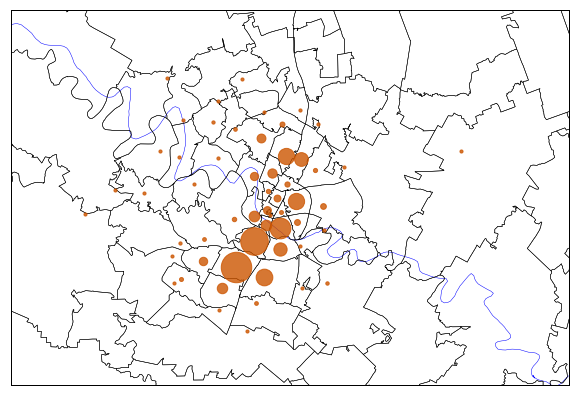

In [13]:
#Plotting the 311 call density on Travis county zip codes marklines.

fig, ax = plt.subplots(figsize=(10,10))
map = Basemap(resolution='f', # c, l, i, h, f or None
            projection='merc',
            lat_0=30.3, lon_0=-97.8,
            llcrnrlon=-98.2, llcrnrlat=30.02, urcrnrlon=-97.2, urcrnrlat=30.6) 

map.drawmapboundary(fill_color="#FFFFFF")
map.drawrivers(color="#0000FF")

map.readshapefile('USzip_codes/cb_2016_us_zcta510_500k', 'cb_2016_us_zcta510_500k')

def plot_area(Coordinates):
    count = atx_zip_by_latlon.loc[atx_zip_by_latlon.Coordinates == Coordinates]["Number of Complaints"]
    x, y = map(Coordinates[1], Coordinates[0])
    #The count number is too high to plot. So reduce it and plot the area of a circle.
    size = (count/6000) ** 2 + 3.14
    map.plot(x, y, 'o', markersize=size, color='#CC5500', alpha=0.8)


atx_zip_by_latlon.Coordinates.apply(plot_area)
fig1 = plt.gcf()
plt.show()
plt.draw()
fig1.savefig('images/311_call_density_zip.png', dpi=200)

### Tom Berton mapped the density of 311 calls as a heatmap on a Google map using the 'gmaps' dependency. And an Google Api Key. 

In [6]:
# Import necessary modules
import gmaps
import json
import gmaps.geojson_geometries
import gmaps.datasets
from config import g_key
gmaps.configure(g_key)

In [7]:
#Draw the Google heatmap using Lat and Lon from 'atx_zip_by_latlon'
with open("travis.geojson") as f:
    geometry = json.load(f)
    
fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(
    atx_zip_by_latlon[["Lat", "Lon"]], weights=atx_zip_by_latlon["Number of Complaints"],
    max_intensity=50, point_radius=7.5)

geojson_layer = gmaps.geojson_layer(geometry, fill_color=None , fill_opacity=0.0)
fig.add_layer(heatmap_layer)
fig.add_layer(geojson_layer)
fig

Figure()

In [8]:
austin_lat_lon['Count'] = (austin_lat_lon['Number of Complaints'] !='').astype(int)
    
austin_lat_lon.head()

,Zip Code,Number of Complaints,Lat,Lon,Count
0,78741,Animal Services Office,30.224549,-97.690675,1
1,78757,Animal Services Office,30.350881,-97.747492,1
2,78744,Animal Services Office,30.199263,-97.711366,1
3,78727,Austin Code Department,30.425112,-97.707188,1
4,78723,Animal Services Office,30.311821,-97.669302,1


In [9]:
#Draw the Google heatmap using Lat and Lon from 'atx_zip_by_latlon'
with open("travis.geojson") as f:
    geometry = json.load(f)
    
fig = gmaps.figure()
heatmap_layer = gmaps.heatmap_layer(
    austin_lat_lon[["Lat", "Lon"]], weights=austin_lat_lon["Count"],
    max_intensity=10, point_radius=0.5)

geojson_layer = gmaps.geojson_layer(geometry, fill_color=None , fill_opacity=0.0)
fig.add_layer(heatmap_layer)
fig.add_layer(geojson_layer)
fig

Figure()